## Transfer Learning w/ Data Augmentation
#### Building a model to classify images as food or nonfood with transfer learning and augmented images

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from glob import glob

import sys, os


#### Loading in the data

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2020-06-14 23:17:14--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 172.67.213.166, 104.31.80.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  29.0MB/s    in 16s     

2020-06-14 23:17:31 (26.3 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [ ]:
!unzip -qq -o Food-5K.zip

In [5]:
cd Food-5K/

/content/Food-5K


In [6]:
cd training/

/content/Food-5K/training


In [7]:
cd ..

/content/Food-5K


In [8]:
mv Food-5K/* .

mv: cannot stat 'Food-5K/*': No such file or directory


In [9]:
ls

evaluation/  training/  validation/


#### Displaying a random image

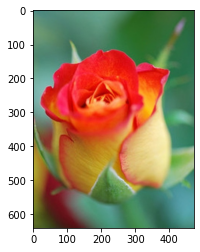

In [10]:
plt.imshow(image.load_img("training/0_808.jpg"))

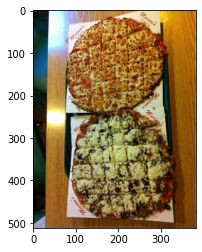

In [11]:
plt.imshow(image.load_img("training/1_616.jpg"))

#### Moving files into appropriate directory to follow Keras API standard

In [ ]:
# Making sub-directories with corresponding names to store the data Keras-style
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [ ]:
#moving images that from previous folders into the appropriate Keras-style folders
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [ ]:
train_path = 'data/train'
valid_path = 'data/test'

In [15]:
IMAGE_SIZE = [224, 224]
#glob is useful in getting the path names of all the image files 
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

#useful for getting the number of classes
folders = glob(train_path + '/*')
folders

['data/train/nonfood', 'data/train/food']

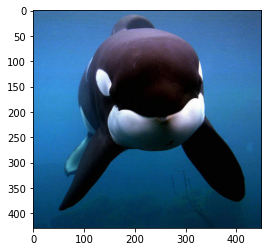

In [16]:
#making sure that the data can be accessed from the paths in image files
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

#### Loading in the model with trained weights

In [17]:
#include top is false as we will specify the head
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)


58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
ptm.trainable = False

In [ ]:
K = len(folders) # number of classes
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [ ]:
model = Model(inputs=ptm.input, outputs=x)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Building the image augmentation generator

In [ ]:
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)

gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

#### Building the training and testing generators

In [23]:
batch_size = 128

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Building and testing the model

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [25]:
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

Epoch 1/10
24/24 [==============================] - 59s 2s/step - loss: 1.4819 - accuracy: 0.9360 - val_loss: 0.6284 - val_accuracy: 0.9750
Epoch 2/10
24/24 [==============================] - 55s 2s/step - loss: 0.4595 - accuracy: 0.9820 - val_loss: 0.7420 - val_accuracy: 0.9800
Epoch 3/10
24/24 [==============================] - 54s 2s/step - loss: 0.2851 - accuracy: 0.9863 - val_loss: 0.7419 - val_accuracy: 0.9790
Epoch 4/10
24/24 [==============================] - 55s 2s/step - loss: 0.3564 - accuracy: 0.9840 - val_loss: 0.7439 - val_accuracy: 0.9750
Epoch 5/10
24/24 [==============================] - 55s 2s/step - loss: 0.2419 - accuracy: 0.9897 - val_loss: 0.6806 - val_accuracy: 0.9790
Epoch 6/10
24/24 [==============================] - 54s 2s/step - loss: 0.3191 - accuracy: 0.9890 - val_loss: 0.7644 - val_accuracy: 0.9750
Epoch 7/10
24/24 [==============================] - 55s 2s/step - loss: 0.1898 - accuracy: 0.9927 - val_loss: 0.5684 - val_accuracy: 0.9800
Epoch 8/10
24/24 [==

#### Evaluating the model

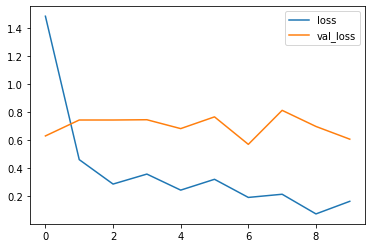

In [26]:
plt.plot(r.history['loss'], label = "loss")
plt.plot(r.history['val_loss'], label = "val_loss")
plt.legend()

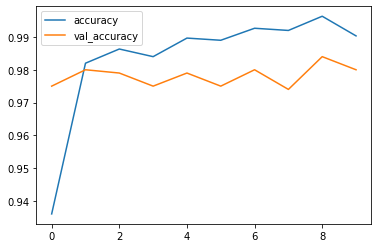

In [27]:
plt.plot(r.history['accuracy'], label = "accuracy")
plt.plot(r.history['val_accuracy'], label = "val_accuracy")
plt.legend()